CHARGEMENT PROPORTIONNEL dataset reel (21 165 images)
Repartition reelle (tous les fichiers) : {'Normal': 10192, 'Lung_Opacity': 6012, 'COVID': 3616, 'Viral Pneumonia': 1345}

Dossier Viral Pneumonia: 1345 images disponibles
   -> Echantillon: 76 images (6.4% du total)

Dossier Lung_Opacity: 6012 images disponibles
   -> Echantillon: 340 images (28.4% du total)

Dossier Normal: 10192 images disponibles
   -> Echantillon: 577 images (48.2% du total)

Dossier COVID: 3616 images disponibles
   -> Echantillon: 205 images (17.1% du total)

1198 images chargees (echantillon proportions reelles)
Repartition echantillon:
label
Normal             577
Lung_Opacity       340
COVID              205
Viral Pneumonia     76
Name: count, dtype: int64

Extraction des features (max 100 images / classe)...
  -> Features: 0/376
  -> Features: 50/376
  -> Features: 100/376
  -> Features: 150/376
  -> Features: 200/376
  -> Features: 250/376
  -> Features: 300/376
  -> Features: 350/376

Features calculees 

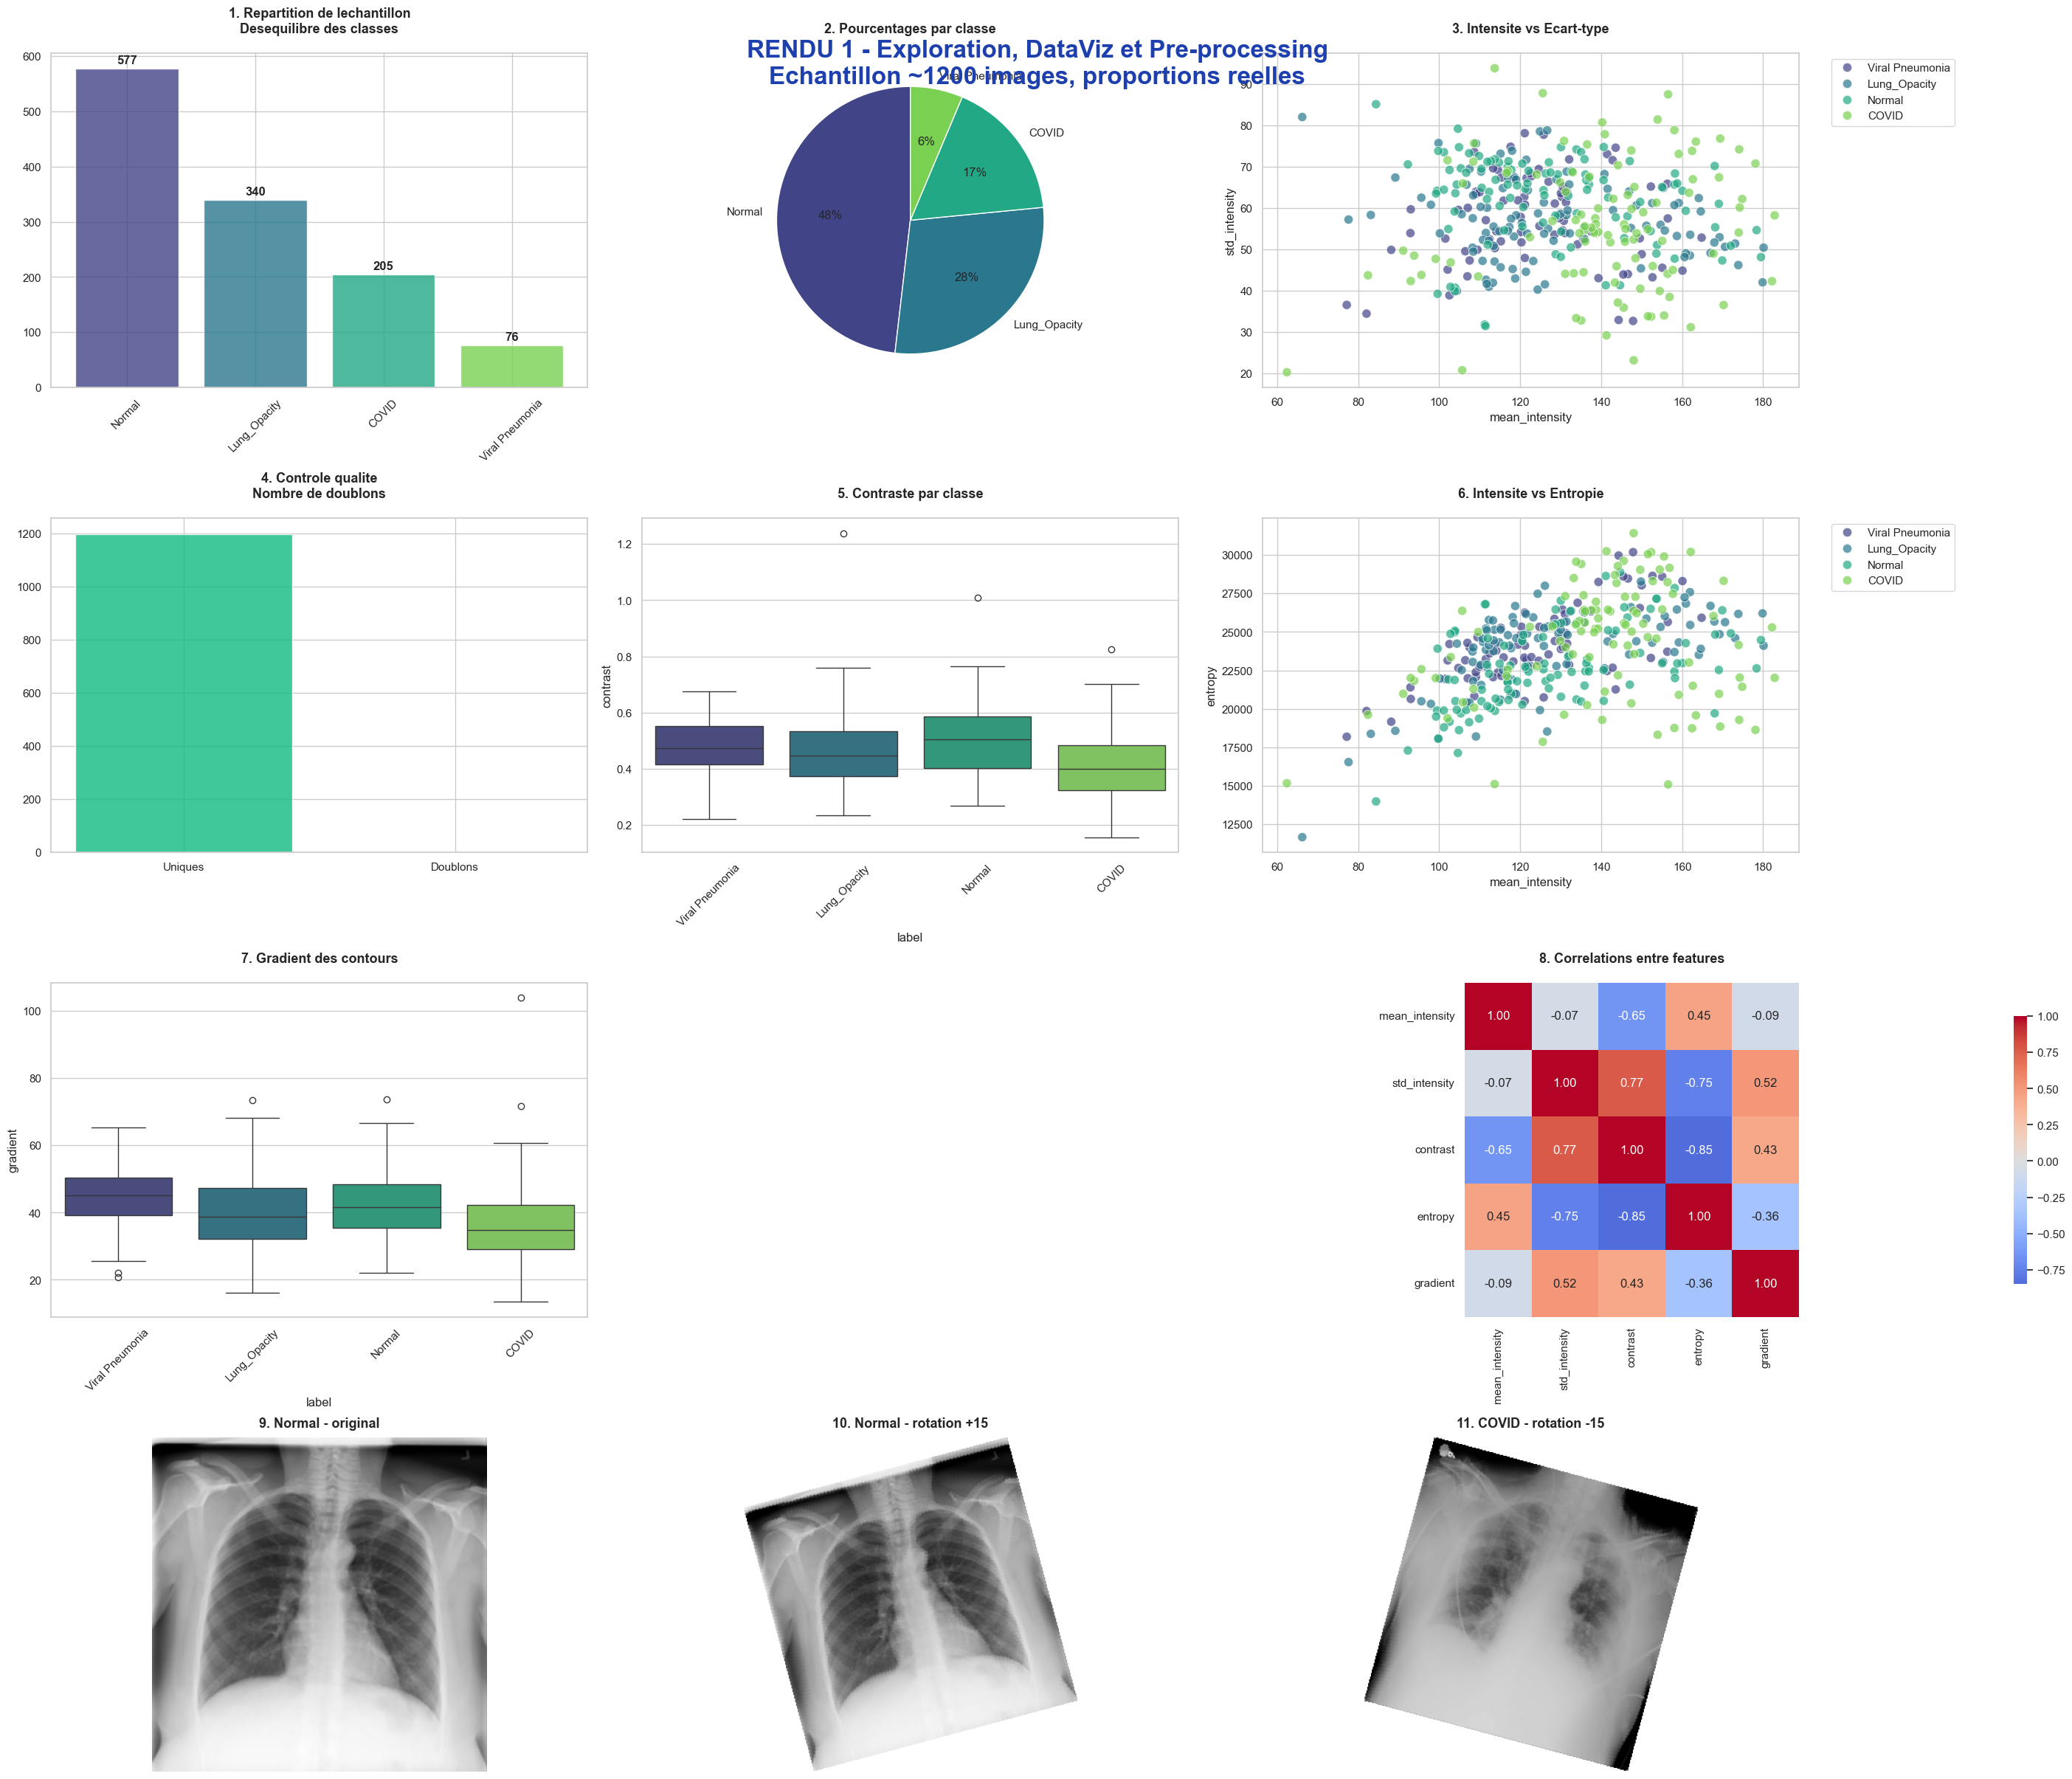

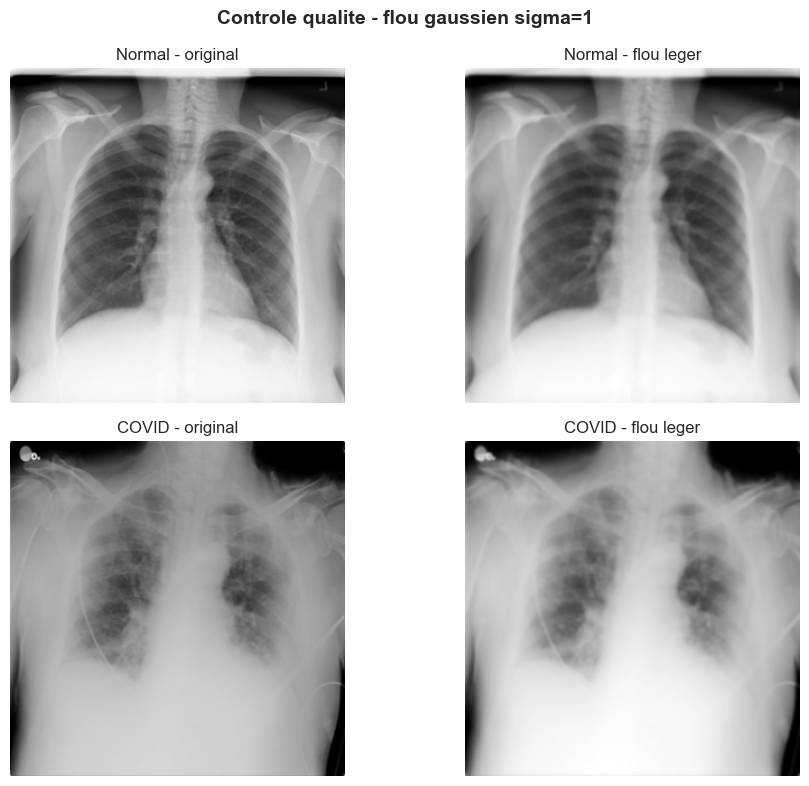


RENDU 1 TERMINE - EXPLORATION + PRE-PROCESSING (Etapes 1 & 2)
Repartition echantillon : {'Normal': 577, 'Lung_Opacity': 340, 'COVID': 205, 'Viral Pneumonia': 76}
   -> Normal: 48.2% | COVID: 17.1%


In [24]:
# ============================
# RENDU 1 - ETAPES 1 & 2
# EXPLORATION + DATAVIZ + PRE-PROCESSING DE BASE
# ============================
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import ndimage
from scipy.ndimage import gaussian_filter

sns.set(style="whitegrid")

# ============================
# 1. CHARGEMENT DATASET (ECHANTILLON PROPORTIONNEL)
# ============================
data_dir = Path("/Users/pcphonemac/Documents/FORMATION DATASCIENTIST/Projet COVID/COVID-19_Radiography_Dataset")

# Comptages officiels du dataset complet
counts_reel = {'Normal': 10192, 'Lung_Opacity': 6012, 'COVID': 3616, 'Viral Pneumonia': 1345}
total_reel = sum(counts_reel.values())

print("CHARGEMENT PROPORTIONNEL dataset reel (21 165 images)")
print(f"Repartition reelle (tous les fichiers) : {counts_reel}")

data = []
for category_dir in data_dir.iterdir():
    if category_dir.is_dir():
        images_dir = category_dir / "images"
        if images_dir.exists():
            count = len(list(images_dir.glob("*.png")))
            print(f"\nDossier {category_dir.name}: {count} images disponibles")

            # Echantillon ~1200 images au total, respectant les proportions reelles
            proportion = counts_reel[category_dir.name] / total_reel
            n_images = max(50, int(1200 * proportion))   # min 50 par classe
            n_images = min(n_images, count)              # pas plus que ce qui existe

            print(f"   -> Echantillon: {n_images} images ({proportion*100:.1f}% du total)")

            for image_file in list(images_dir.glob("*.png"))[:n_images]:
                data.append({
                    "image_path": str(image_file),
                    "label": category_dir.name
                })

df_images = pd.DataFrame(data)
print(f"\n{len(df_images)} images chargees (echantillon proportions reelles)")
print("Repartition echantillon:")
print(df_images['label'].value_counts())

# ============================
# 2. FEATURES RAPIDES (INTENSITE / CONTRASTE / ENTROPIE / GRADIENT)
# ============================
def extract_image_features_fast(image_path):
    """
    5 features d'intensite / texture :
    - mean_intensity : intensite moyenne
    - std_intensity  : ecart-type (contraste brut)
    - contrast       : contraste normalise
    - entropy        : complexite de texture
    - gradient       : intensite des contours (lesions)
    """
    img = Image.open(image_path).convert('L')
    arr = np.array(img, dtype=np.float32)

    mean_int = arr.mean()
    std_int = arr.std()
    contrast = std_int / (mean_int + 1e-8)
    entropy = -np.sum((arr/255)**2 * np.log((arr/255)**2 + 1e-8))
    gradient = ndimage.sobel(arr).std()

    return pd.Series({
        'mean_intensity': mean_int,
        'std_intensity': std_int,
        'contrast': contrast,
        'entropy': entropy,
        'gradient': gradient
    })

print("\nExtraction des features (max 100 images / classe)...")
df_sample = (
    df_images
    .groupby('label', group_keys=False)
    .head(100)
    .reset_index(drop=True)
)

features_list = []
for i, row in df_sample.iterrows():
    if i % 50 == 0:
        print(f"  -> Features: {i}/{len(df_sample)}")
    features_list.append(extract_image_features_fast(row['image_path']))

df_features = pd.concat([df_sample[['label']], pd.DataFrame(features_list)], axis=1)
print(f"\nFeatures calculees pour exploration : {df_features.shape}")

# ============================
# 3. FONCTION DE ROTATION (PRE-PROCESSING / AUGMENTATION SIMPLE)
# ============================
def rotate_augmentation(image_path, angle=15):
    """
    Data augmentation par rotation +-15 degres.
    Utilisee comme pre-processing simple pour :
    - robustesse du futur modele a la position du patient
    - enrichir visuellement les classes minoritaires (COVID, etc.)
    """
    img = Image.open(image_path).convert('L')
    rotated = img.rotate(angle, expand=True, fillcolor=255)  # fond blanc
    return np.array(rotated)

# ============================
# 4. GRAPHIQUES – EXPLORATION + PRE-PROCESSING
# ============================
fig = plt.figure(figsize=(28, 24), constrained_layout=True)
gs = fig.add_gridspec(4, 3)

# G1: Repartition de l'echantillon
ax1 = fig.add_subplot(gs[0, 0])
counts = df_images['label'].value_counts()
bars = ax1.bar(counts.index, counts.values, color=sns.color_palette('viridis', 4), alpha=0.8)
ax1.set_title('1. Repartition de lechantillon\nDesequilibre des classes', fontsize=13, fontweight='bold', pad=20)
ax1.tick_params(axis='x', rotation=45)
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# G2: Camembert des pourcentages par classe
ax2 = fig.add_subplot(gs[0, 1])
ax2.pie(counts.values, labels=counts.index, autopct='%1.0f%%',
        colors=sns.color_palette('viridis', 4), startangle=90)
ax2.set_title('2. Pourcentages par classe', fontsize=13, fontweight='bold', pad=20)

# G3: Intensite moyenne vs ecart-type
ax3 = fig.add_subplot(gs[0, 2])
sns.scatterplot(data=df_features, x='mean_intensity', y='std_intensity',
                hue='label', s=80, alpha=0.7, ax=ax3, palette='viridis')
ax3.set_title('3. Intensite vs Ecart-type', fontsize=13, fontweight='bold', pad=20)
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# G4: Controle qualite – doublons
ax4 = fig.add_subplot(gs[1, 0])
dupes = df_images['image_path'].duplicated().sum()
ax4.bar(['Uniques', 'Doublons'], [len(df_images) - dupes, dupes],
        color=['#10b981', '#ef4444'], alpha=0.8)
ax4.set_title('4. Controle qualite\nNombre de doublons', fontsize=13, fontweight='bold', pad=20)

# G5: Boxplot contraste (corrige)
ax5 = fig.add_subplot(gs[1, 1])
sns.boxplot(
    x='label', y='contrast',
    data=df_features,
    hue='label',
    dodge=False,
    ax=ax5,
    palette='viridis'
)
ax5.set_title('5. Contraste par classe', fontsize=13, fontweight='bold', pad=20)
ax5.tick_params(axis='x', rotation=45)

# G6: Intensite vs entropie
ax6 = fig.add_subplot(gs[1, 2])
sns.scatterplot(data=df_features, x='mean_intensity', y='entropy',
                hue='label', s=80, alpha=0.7, ax=ax6, palette='viridis')
ax6.set_title('6. Intensite vs Entropie', fontsize=13, fontweight='bold', pad=20)
ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# G7: Boxplot gradient
ax7 = fig.add_subplot(gs[2, 0])
sns.boxplot(
    x='label', y='gradient',
    data=df_features,
    hue='label',
    dodge=False,
    ax=ax7,
    palette='viridis'
)
ax7.set_title('7. Gradient des contours', fontsize=13, fontweight='bold', pad=20)
ax7.tick_params(axis='x', rotation=45)

# G8: Matrice de correlation des 5 features
ax8 = fig.add_subplot(gs[2, 1:])
corr_matrix = df_features[['mean_intensity', 'std_intensity', 'contrast', 'entropy', 'gradient']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=ax8,
            cbar_kws={'shrink': 0.8}, fmt='.2f', square=True)
ax8.set_title('8. Correlations entre features', fontsize=13, fontweight='bold', pad=20)

# G9–G11 : Demonstration de la rotation
sample_normal = df_images[df_images['label'] == 'Normal'].iloc[0]
sample_covid = df_images[df_images['label'] == 'COVID'].iloc[0]

# G9: Normal originale
img_original = Image.open(sample_normal['image_path']).convert('L')
ax9 = fig.add_subplot(gs[3, 0])
ax9.imshow(np.array(img_original), cmap='gray')
ax9.set_title('9. Normal - original', fontsize=13, fontweight='bold', pad=10)
ax9.axis('off')

# G10: Normal rotatee +15°
img_rot_pos = rotate_augmentation(sample_normal['image_path'], angle=15)
ax10 = fig.add_subplot(gs[3, 1])
ax10.imshow(img_rot_pos, cmap='gray')
ax10.set_title('10. Normal - rotation +15', fontsize=13, fontweight='bold', pad=10)
ax10.axis('off')

# G11: COVID rotatee -15°
img_rot_neg_covid = rotate_augmentation(sample_covid['image_path'], angle=-15)
ax11 = fig.add_subplot(gs[3, 2])
ax11.imshow(img_rot_neg_covid, cmap='gray')
ax11.set_title('11. COVID - rotation -15', fontsize=13, fontweight='bold', pad=10)
ax11.axis('off')

plt.suptitle(
    "RENDU 1 - Exploration, DataViz et Pre-processing\nEchantillon ~1200 images, proportions reelles",
    fontsize=24, fontweight='bold', y=0.98, color='#1e40af'
)

plt.savefig('RENDU1_11_GRAPHIQUES_FINAL.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# ============================
# 5. CONTROLE QUALITE VISUEL - BRUIT / FLOU LEGER
# ============================
sample_normal_path = sample_normal['image_path']
sample_covid_path  = sample_covid['image_path']

img_norm = np.array(Image.open(sample_normal_path).convert('L'), dtype=np.float32)
img_covid = np.array(Image.open(sample_covid_path).convert('L'), dtype=np.float32)

img_norm_blur  = gaussian_filter(img_norm, sigma=1.0)
img_covid_blur = gaussian_filter(img_covid, sigma=1.0)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Controle qualite - flou gaussien sigma=1", fontsize=14, fontweight='bold')

axes[0,0].imshow(img_norm, cmap='gray')
axes[0,0].set_title("Normal - original")
axes[0,0].axis('off')

axes[0,1].imshow(img_norm_blur, cmap='gray')
axes[0,1].set_title("Normal - flou leger")
axes[0,1].axis('off')

axes[1,0].imshow(img_covid, cmap='gray')
axes[1,0].set_title("COVID - original")
axes[1,0].axis('off')

axes[1,1].imshow(img_covid_blur, cmap='gray')
axes[1,1].set_title("COVID - flou leger")
axes[1,1].axis('off')

plt.tight_layout()
plt.savefig("controle_qualite_blur_rendu1.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# ============================
# 6. RECAP
# ============================
print("\n" + "="*80)
print("RENDU 1 TERMINE - EXPLORATION + PRE-PROCESSING (Etapes 1 & 2)")
print("="*80)

counts_pct = counts / len(df_images) * 100
print(f"Repartition echantillon : {counts.to_dict()}")
print(f"   -> Normal: {counts_pct['Normal']:.1f}% | COVID: {counts_pct['COVID']:.1f}%")

df_images.to_csv('df_images_rendu1.csv', index=False)
df_features.to_csv('df_features_rendu1.csv', index=False)